### Прогнозирование возраста морского ушка на основе физических измерений.

Возраст морского ушка определяется путем разрезания оболочки через конус, ее окрашивания и подсчета количества колец через микроскоп - скучная и трудоемкая задача.  Другие измерения, которые легче получить, используются для прогнозирования возраста.  Для решения этой задачи может потребоваться дополнительная информация, например, о погодных условиях и местоположении (отсюда и наличие продовольствия).


Дано имя атрибута, тип атрибута, единица измерения и
краткое описание. Количество колец - это значение для прогнозирования: либо
как непрерывное значение или как проблема классификации.

| Название | Тип данных | Измер. | Описание |
|---------|----------|------------|----|
| Пол | именной | - | M, F и I (младенец)
| Длина | непрерывная | мм. | Самое длинное измерение раковины
| Диаметр | непрерывного | мм. | перпендикулярно длине
| Высота | непрерывного | мм. | с мясом в скорлупе
| Общий вес | непрерывного | граммы | всего ушка
| Перемешанный вес | непрерывного | граммы | веса мяса
| Вес внутренностей | непрерывный | граммы | веса кишечника (после кровотечения)
| Вес скорлупы | непрерывный | граммы  | после сушки
| Кольца | целые | - | +1,5 дает возраст в годах

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC, SVR, LinearSVR, NuSVR
from sklearn.model_selection import train_test_split

In [34]:
def test_model(train_X, train_y, test_X, test_y, model, params=[{}]):
    for param in params:
        test_model = model(**param)
        test_model.fit(train_X, train_y)
        print("Параметры:", param)
        print("Оценка:", test_model.score(test_X, test_y))

In [22]:
data_path = './data/abalone.csv'

In [23]:
df = pd.read_csv(data_path)

In [24]:
df.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


На основе интуитивных соображений.

Размеры самок обычно наибольшие в популяции, далее за ними идут самцы (тк им нет необходимости создавать потомство), после самцов меньше обычно подрастающее поколение.

На основе этой догадки преобразуем класс Пол в цифровое значени

In [25]:
def sex_transform(s):
    s2n_map = {
        "M": 0.5,
        "F": 1,
        "I": 0
    }
    return s2n_map[s]

df.Sex = df.Sex.transform(sex_transform)

In [26]:
df.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,0.5,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.5,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1.0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.5,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


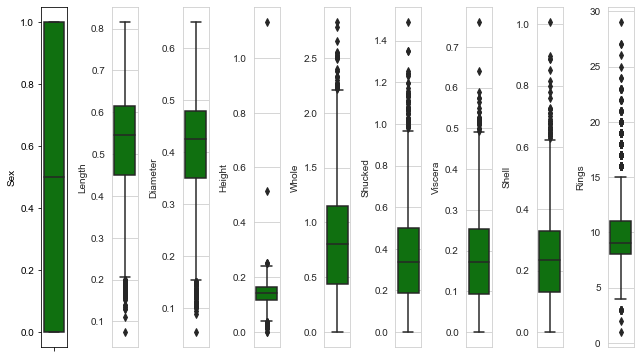

In [27]:
l = df.columns.values
number_of_columns=9
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='green',orient='v')
    plt.tight_layout()

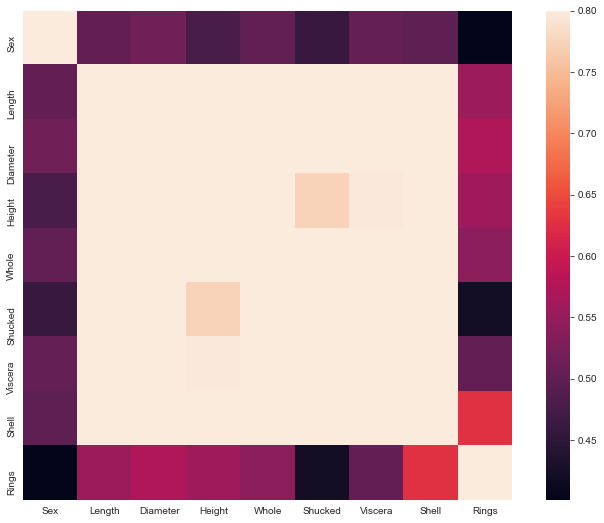

In [8]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

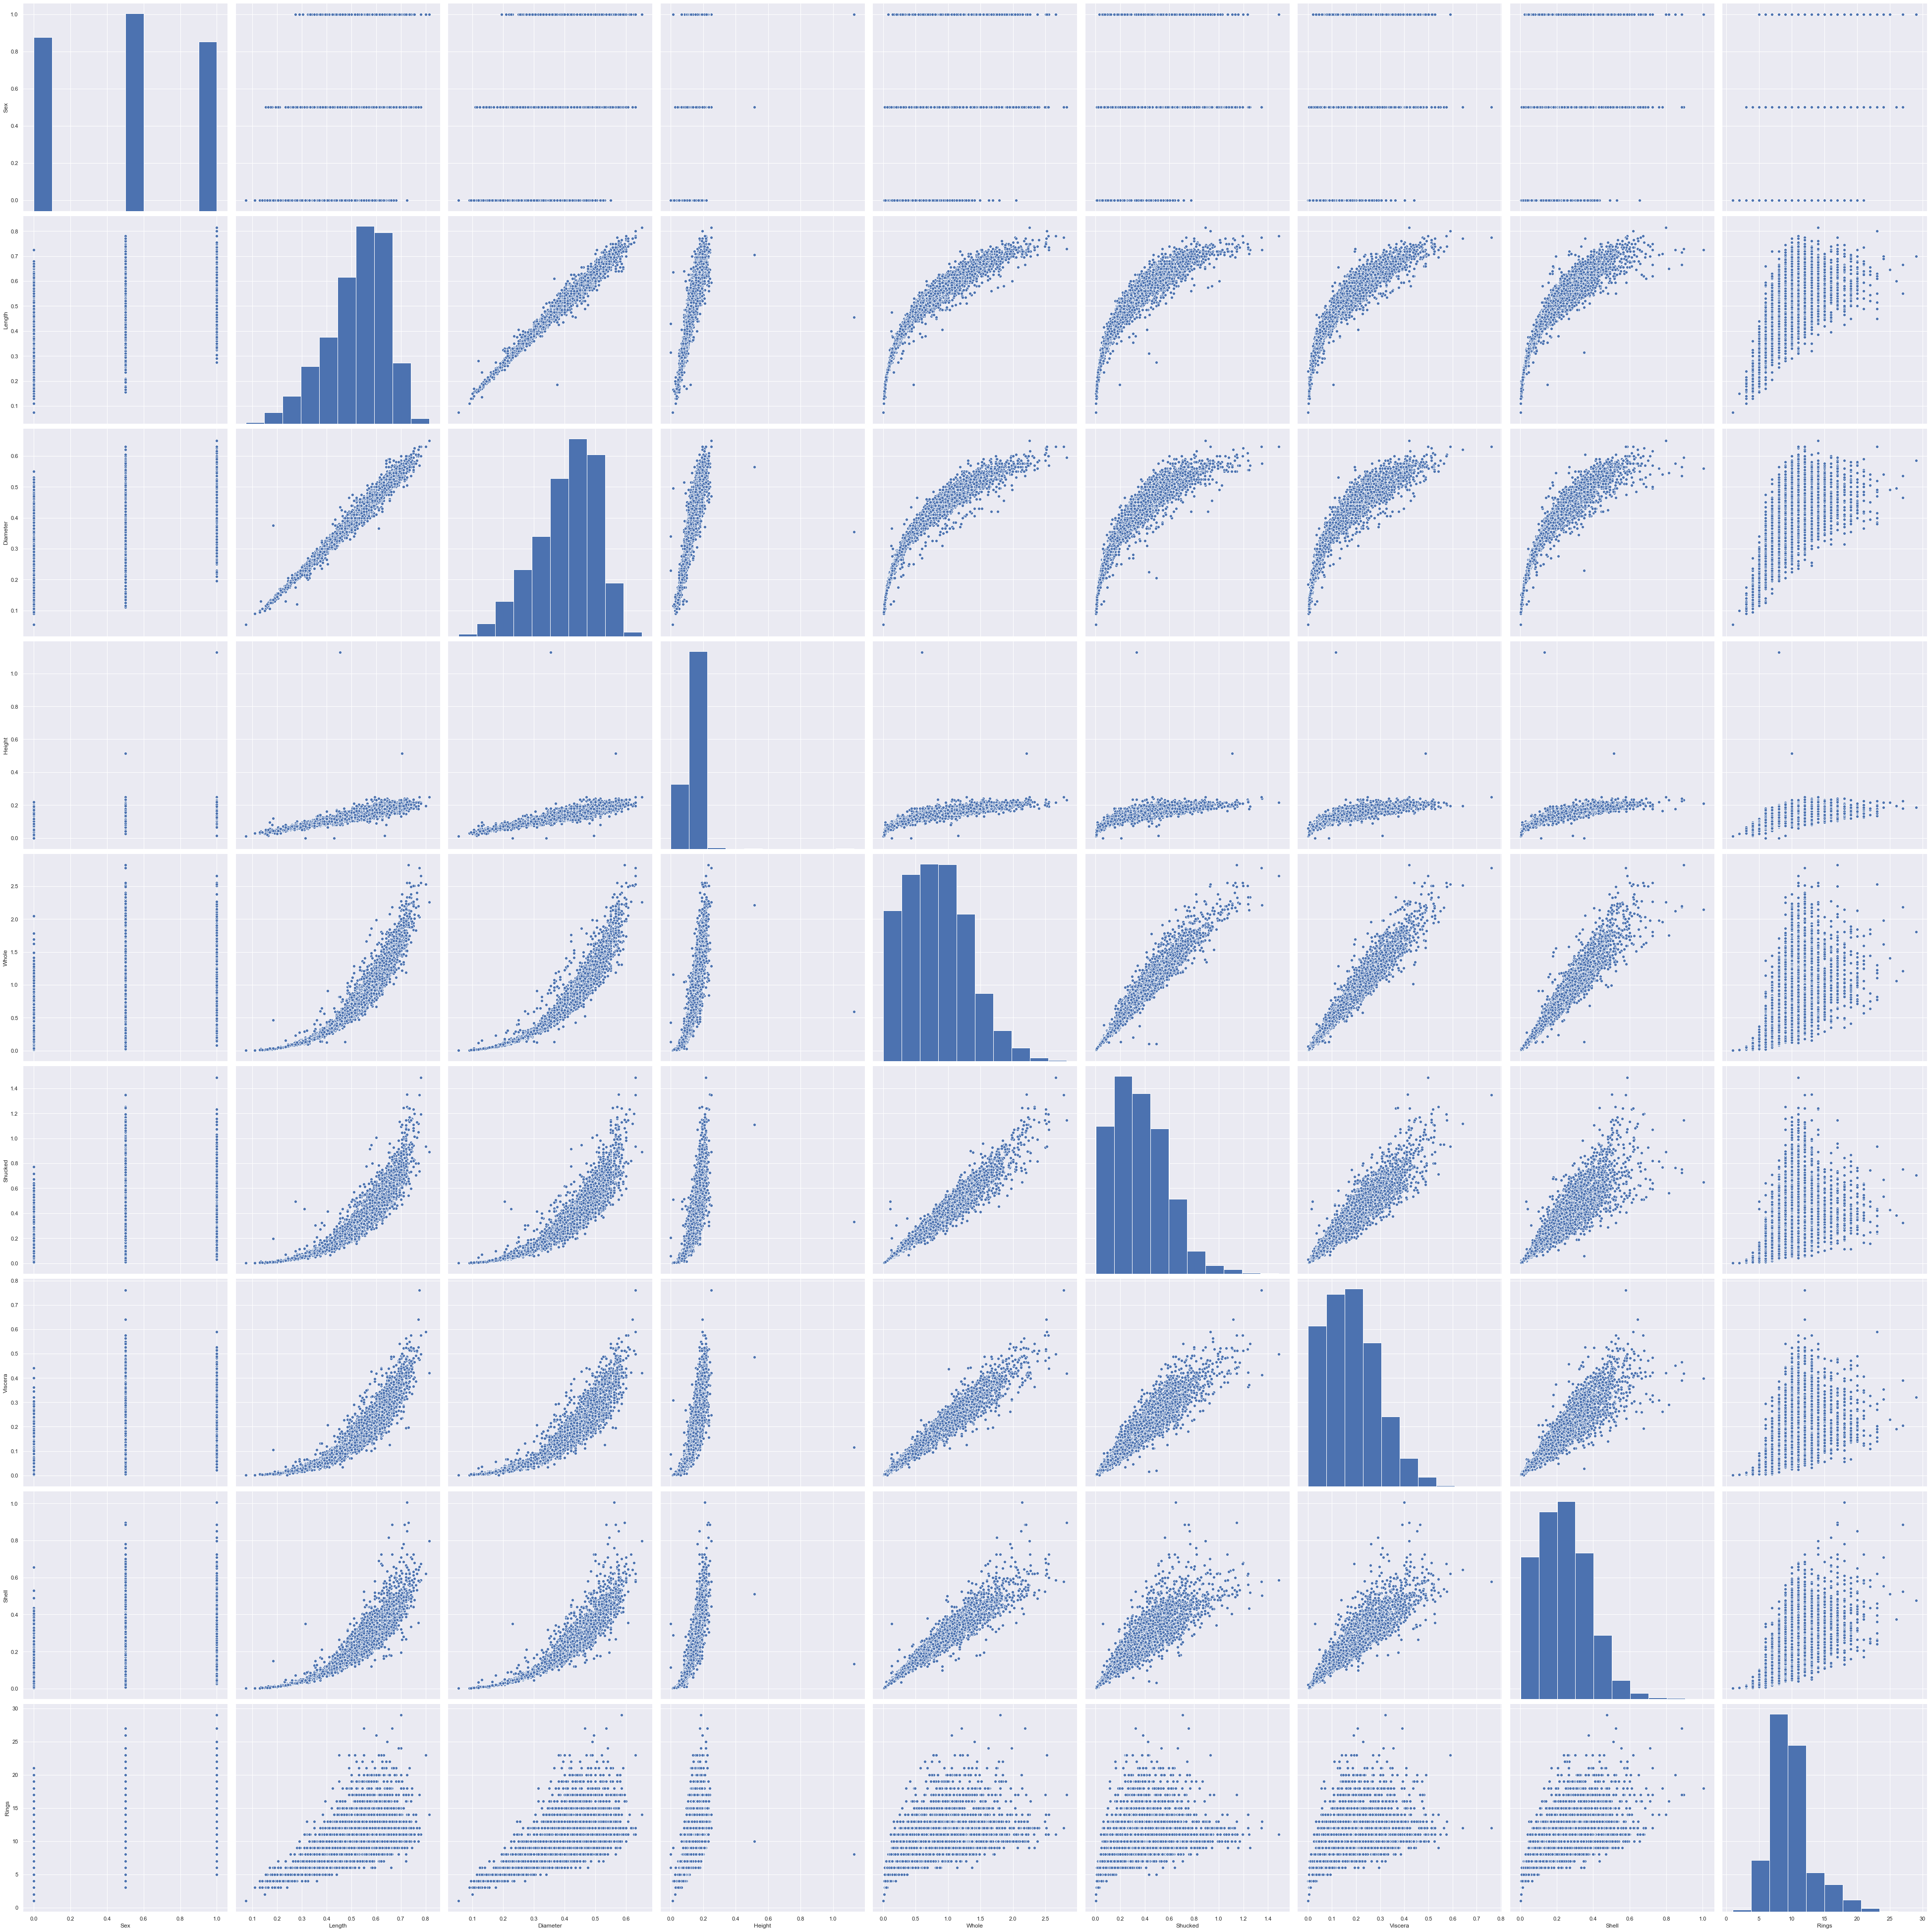

In [9]:
sns.set()
sns.pairplot(df, height = 6)
plt.show();

(картинка генерится качественная нужно просто просмотреть не через ноутбук)

Из графиков выше видно что между почти всеми параметрами прослеживается кореляция. Так же оказалась верна наша догадка насчет пола и их числовых эквивалентов.

In [35]:
X_data, Y_data = df.loc[:,:"Shell"], df["Rings"]

X_train,  X_test,  y_train,  y_test =  train_test_split(X_data, Y_data,  test_size= 0.20,  random_state= 42 )

In [36]:
test_model(X_train, y_train, X_test, y_test, LinearRegression)

Параметры: {}
Оценка: 0.5434892897754016


Если судить по документации sklearn то идеальная модель линейной регрессии выдаст оценку близкую к единице. В нашем случае мы видим что наша модель близка к простому угадыванию. Если снова взглянуть на графики то появляется предположение что в данном случае нам поможет полином второй степени.

In [38]:
poly = PolynomialFeatures(degree = 2)

test_model(poly.fit_transform(X_train), y_train, poly.transform(X_test), y_test, LinearRegression)

Параметры: {}
Оценка: 0.5510137630154736


Результат практически не изменился - пришло время нейронок (нет)

In [42]:
params = [
    {'kernel': 'linear', 'gamma':'auto'}, 
    {'kernel': 'poly', 'degree': 2, 'gamma':'auto'}, 
    {'kernel': 'rbf', 'gamma':'auto'}, 
    {'kernel': 'sigmoid', 'gamma':'auto'}]

test_model(X_train, y_train, X_test, y_test, SVC, params=params)

Параметры: {'kernel': 'linear', 'gamma': 'auto'}
Оценка: 0.2631578947368421
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}
Оценка: 0.19617224880382775
Параметры: {'kernel': 'rbf', 'gamma': 'auto'}
Оценка: 0.25478468899521534
Параметры: {'kernel': 'sigmoid', 'gamma': 'auto'}
Оценка: 0.23803827751196172


Возможно я где-то накосячил с параметрами, но результат хуже чем с линейной регрессией 

In [57]:
params = [
    {'kernel': 'linear', 'gamma':'auto'}, 
    {'kernel': 'poly', 'degree': 2, 'gamma':'auto'}, 
    {'kernel': 'rbf', 'gamma':'auto'}]

test_model(X_train, y_train, X_test, y_test, SVR, params=params)

Параметры: {'kernel': 'linear', 'gamma': 'auto'}
Оценка: 0.4964165882958131
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}
Оценка: 0.3443396269934965
Параметры: {'kernel': 'rbf', 'gamma': 'auto'}
Оценка: 0.4553251121531404


In [51]:
params = [
    {'C':1.0, 'max_iter':100000}, 
    {'C':5.0, 'max_iter':100000}, 
    {'C':125.0, 'max_iter':100000},
    {'C':625.0, 'max_iter':100000},
    {'C':2500.0, 'max_iter':100000},
    {'C':12500.0, 'max_iter':100000},
    {'C':62500.0, 'max_iter':1000000},]

test_model(X_train, y_train, X_test, y_test, LinearSVR, params=params)

Параметры: {'C': 1.0, 'max_iter': 100000}
Оценка: 0.4962947977799004
Параметры: {'C': 5.0, 'max_iter': 100000}
Оценка: 0.5198119604391072
Параметры: {'C': 125.0, 'max_iter': 100000}
Оценка: 0.5259554932943173
Параметры: {'C': 625.0, 'max_iter': 100000}
Оценка: 0.5243150103471117


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Параметры: {'C': 2500.0, 'max_iter': 100000}
Оценка: 0.5305426980418013


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Параметры: {'C': 12500.0, 'max_iter': 100000}
Оценка: 0.5157986622695425
Параметры: {'C': 62500.0, 'max_iter': 1000000}
Оценка: 0.5345243468271095


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [79]:
params = [{'nu':x, 'gamma':'auto'} for x in [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]]

test_model(X_train, y_train, X_test, y_test, NuSVR, params=params)

Параметры: {'nu': 0.01, 'gamma': 'auto'}
Оценка: -0.6385428268061901
Параметры: {'nu': 0.1, 'gamma': 'auto'}
Оценка: 0.24322436370340805
Параметры: {'nu': 0.2, 'gamma': 'auto'}
Оценка: 0.41345054303075957
Параметры: {'nu': 0.3, 'gamma': 'auto'}
Оценка: 0.4527571114216454
Параметры: {'nu': 0.4, 'gamma': 'auto'}
Оценка: 0.46437462174978894
Параметры: {'nu': 0.5, 'gamma': 'auto'}
Оценка: 0.46634867041258404
Параметры: {'nu': 0.6, 'gamma': 'auto'}
Оценка: 0.4635329901451314
Параметры: {'nu': 0.7, 'gamma': 'auto'}
Оценка: 0.46008419161587893
Параметры: {'nu': 0.8, 'gamma': 'auto'}
Оценка: 0.4554789944302678
Параметры: {'nu': 0.9, 'gamma': 'auto'}
Оценка: 0.45508707464759546
Параметры: {'nu': 1.0, 'gamma': 'auto'}
Оценка: 0.4559461973557853


Попробуем удалить часть данных, т.к. в них явно есть избыточность.

| Название | Тип данных | Измер. | Описание |
|---------|----------|------------|----|
| Пол | именной | - | M, F и I (младенец)
| Длина | непрерывная | мм. | Самое длинное измерение раковины
| Диаметр | непрерывного | мм. | перпендикулярно длине
| Высота | непрерывного | мм. | с мясом в скорлупе
| Общий вес | непрерывного | граммы | всего ушка
| Перемешанный вес | непрерывного | граммы | веса мяса
| Вес внутренностей | непрерывный | граммы | веса кишечника (после кровотечения)
| Вес скорлупы | непрерывный | граммы  | после сушки
| Кольца | целые | - | +1,5 дает возраст в годах

Можно удалить общий вес, т.к. его можно вычислить как сумму остального


In [67]:
X_data_clean, Y_data_clean = df.loc[:,:"Shell"], df["Rings"]
del X_data_clean['Whole']

X_train_clean,  X_test_clean,  y_train_clean,  y_test_clean =  train_test_split(X_data_clean, Y_data_clean,  test_size= 0.20,  random_state= 42 )

Протестируем все наши модели снова:

In [68]:
print("Линейная регрессия:")
test_model(X_train_clean, y_train_clean, X_test_clean, y_test_clean, LinearRegression)
print("Полиномиальная регрессия:")
poly = PolynomialFeatures(degree = 2)

test_model(poly.fit_transform(X_train_clean), y_train_clean, poly.transform(X_test_clean), y_test_clean, LinearRegression)

print("SVM:")
params = [
    {'kernel': 'linear', 'gamma':'auto'}, 
    {'kernel': 'poly', 'degree': 2, 'gamma':'auto'}, 
    {'kernel': 'rbf', 'gamma':'auto'}]

test_model(X_train_clean, y_train_clean, X_test_clean, y_test_clean, SVR, params=params)

Линейная регрессия:
Параметры: {}
Оценка: 0.5183230584579523
Полиномиальная регрессия:
Параметры: {}
Оценка: 0.531063335323595
SVM:
Параметры: {'kernel': 'linear', 'gamma': 'auto'}
Оценка: 0.47684192527985736
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}
Оценка: 0.307228619998955
Параметры: {'kernel': 'rbf', 'gamma': 'auto'}
Оценка: 0.4389741781681621


Попробуем выбросить пол

In [80]:
X_data_clean, Y_data_clean = df.loc[:,:"Shell"], df["Rings"]
del X_data_clean['Sex']

X_train_clean,  X_test_clean,  y_train_clean,  y_test_clean =  train_test_split(X_data_clean, Y_data_clean,  test_size= 0.20,  random_state= 42 )

print("Линейная регрессия:")
test_model(X_train_clean, y_train_clean, X_test_clean, y_test_clean, LinearRegression)
print("Полиномиальная регрессия:")
poly = PolynomialFeatures(degree = 2)

test_model(poly.fit_transform(X_train_clean), y_train_clean, poly.transform(X_test_clean), y_test_clean, LinearRegression)

print("SVM:")
params = [
    {'kernel': 'linear', 'gamma':'auto'}, 
    {'kernel': 'poly', 'degree': 2, 'gamma':'auto'}, 
    {'kernel': 'rbf', 'gamma':'auto'}]

test_model(X_train_clean, y_train_clean, X_test_clean, y_test_clean, SVR, params=params)

Линейная регрессия:
Параметры: {}
Оценка: 0.5329844757724522
Полиномиальная регрессия:
Параметры: {}
Оценка: 0.536670178694895
SVM:
Параметры: {'kernel': 'linear', 'gamma': 'auto'}
Оценка: 0.48071264424649335
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}
Оценка: 0.3227199416301276
Параметры: {'kernel': 'rbf', 'gamma': 'auto'}
Оценка: 0.43567587092891946


Попробуем тогда убрать вообще все параметры, кроме массы и диаметра ракушки

In [73]:
X_data_clean, Y_data_clean = df.loc[:,["Shell","Diameter"]], df["Rings"]

X_train_clean,  X_test_clean,  y_train_clean,  y_test_clean =  train_test_split(X_data_clean, Y_data_clean,  test_size= 0.20,  random_state= 42 )

print("Линейная регрессия:")
test_model(X_train_clean, y_train_clean, X_test_clean, y_test_clean, LinearRegression)
print("Полиномиальная регрессия:")
poly = PolynomialFeatures(degree = 2)

test_model(poly.fit_transform(X_train_clean), y_train_clean, poly.transform(X_test_clean), y_test_clean, LinearRegression)

print("SVM:")
params = [
    {'kernel': 'linear', 'gamma':'auto'}, 
    {'kernel': 'poly', 'degree': 2, 'gamma':'auto'}, 
    {'kernel': 'rbf', 'gamma':'auto'}]

test_model(X_train_clean, y_train_clean, X_test_clean, y_test_clean, SVR, params=params)

Линейная регрессия:
Параметры: {}
Оценка: 0.4014801558732751
Полиномиальная регрессия:
Параметры: {}
Оценка: 0.43934266868455973
SVM:
Параметры: {'kernel': 'linear', 'gamma': 'auto'}
Оценка: 0.35772084453206654
Параметры: {'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}
Оценка: 0.3028957849790819
Параметры: {'kernel': 'rbf', 'gamma': 'auto'}
Оценка: 0.3659182214096165
